In [146]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [147]:
df = pd.read_csv('CombinedTestResultMetric.csv')
df.drop(['participantCreatedOn', 'testResultMetricCreatedOn', 'testResultMetricTimestamp1', 'testResultMetricTimestamp2', 'Unnamed: 19'], axis = 1, inplace = True)
df['testStartedAt'] = df['testStartedAt'].apply(lambda x: pd.to_datetime(x[0:-10]))
df['testEndedAt'] = df['testEndedAt'].apply(lambda x: pd.to_datetime(x[0:-10]))
# df['timecomplete'] = (df['testEndedAt'] - df['testStartedAt']).apply(lambda x: x.seconds)

In [148]:
df['age'] = [df.testStartedAt[i].year - df.participantBirthYear[i] 
                    for i in range(0, len(df))]
df.drop(['participantBirthYear', 'testStartedAt', 'testEndedAt'], axis = 1, inplace = True)

# df['participantSex'].replace(['male', 'female'], [0, 1], inplace = True)

df['participantIsControl'].replace([True, False], ['HC', 'MS'], inplace = True)

In [149]:
def aggdf(df, agg, colname):
    agg = df.groupby(['floodlightOpenId', 'testCode', 'testMetricCode']).agg('{}'.format(agg))[['testResultMetricValue']]
    agg.columns = ['{}'.format(colname)]
    agg_reset = agg.reset_index()
    agg_reset['test'] = agg_reset['testCode'] + agg_reset['testMetricCode']
    aggtest = agg_reset.drop(['testCode', 'testMetricCode'], axis = 1)
    aggtest = aggtest.set_index(['floodlightOpenId', 'test'])
    aggtest = aggtest.reset_index()
    aggtest = aggtest.pivot(index='floodlightOpenId', columns='test', values=['{}'.format(colname)])
    aggtest.columns = [col[0]+col[1] for col in aggtest.columns]
    return aggtest

In [150]:
meantest = aggdf(df, 'mean', 'val_mean')
vartest = aggdf(df, 'var', 'val_var')

In [151]:
count = df.groupby(['floodlightOpenId', 'testCode', 'testMetricCode']).count()[['testResultMetricValue']]
count.columns = ['test_count']
count_reset = count.reset_index()
count_reset['test'] = count_reset['testCode'] + count_reset['testMetricCode']
counttest = count_reset.drop(['testCode', 'testMetricCode'], axis = 1)
counttest = counttest.set_index(['floodlightOpenId', 'test'])
counttest = counttest.reset_index()
counttest = counttest.pivot(index='floodlightOpenId', columns='test', values='test_count')
counttest.columns = [col[0]+'_count' for col in counttest.columns]

In [152]:
dfs = [meantest, vartest, counttest]
maindf = pd.concat(dfs, axis=1)

In [153]:
names = ['mood', 'bottomtop', 'circle', 'figure8', 'shapehand', 'meandrawdist', 'numshapes', 'spiral', 'square',
        'topbottom', 'turnspeed', 'turns', 'ips', 'ipstime', 'bips', 'bipstime', 'mobility', 'pinchhand', 'pinches',
        'sway', 'steps']

In [154]:
def cols(names, metric):
    allcols = []
    for name in names: 
        allcols.append(name + '_' + metric)
    return allcols

In [155]:
meancols = cols(names, 'mean')
varcols = cols(names, 'var')
countcols = cols(names, 'count')

In [156]:
allcols = meancols + varcols + countcols

In [157]:
maindf.columns = allcols

In [158]:
diagnosis = df.groupby(['floodlightOpenId', 'participantIsControl']).size().reset_index()[['floodlightOpenId', 'participantIsControl']]
sex = df.groupby(['floodlightOpenId', 'participantSex']).size().reset_index()[['floodlightOpenId', 'participantSex']]
country = df.groupby(['floodlightOpenId', 'participantCountryOfResidence']).size().reset_index(name='Time')[['floodlightOpenId', 'participantCountryOfResidence']]
age = df.groupby(['floodlightOpenId']).mean().reset_index()[['floodlightOpenId', 'age']]
weight = df.groupby(['floodlightOpenId']).mean().reset_index()[['floodlightOpenId', 'participantWeightLbs']]
height = df.groupby(['floodlightOpenId']).mean().reset_index()[['floodlightOpenId', 'participantHeightCms']]


In [159]:
maindf['sex'] = list(sex['participantSex'])
maindf['country'] = list(country['participantCountryOfResidence'])
maindf['age'] = list(age['age'])
maindf['weight'] = list(weight['participantWeightLbs'])
maindf['height'] = list(height['participantHeightCms'])
maindf['diagnosis'] = list(diagnosis['participantIsControl'])

In [160]:
def fillvar(df, metric):
    col = np.where(((maindf['{}_var'.format(metric)].isna()) & (maindf['{}_count'.format(metric)] == 1)), 
             0, maindf['{}_var'.format(metric)])
    return col

In [161]:
for name in names: 
    maindf['{}_var'.format(name)] = fillvar(maindf, name)

In [162]:
maindf['height'] = maindf['height'].apply(lambda x: x/100)

In [163]:
maindf['weight'] = maindf['weight'].apply(lambda x: x*0.454)

In [164]:
maindf['BMI'] = maindf['weight'] / (maindf['height'] **2)

In [165]:
# sum(maindf.isnull().mean(axis=1) > 0.5)

thresh = len(maindf) * .5
maindf.dropna(thresh = thresh, axis = 1, inplace = True)

In [166]:
threshc = len(maindf.columns) * .5
maindf.dropna(thresh = threshc, axis = 0, inplace = True)

In [167]:
# print(sum(maindf.isnull().mean(axis=1) > 0.5))
# print(sum(maindf.isnull().mean(axis=0) > 0.5))

In [168]:
def fillna(df, metric):
    df = maindf['{}'.format(metric)].fillna(df.groupby('diagnosis')['{}'.format(metric)].transform('mean'))
    return df

for col in list(maindf.columns): 
    if maindf[col].isna().any():
        maindf['{}'.format(col)] = fillna(maindf, col)



In [169]:
maindf.drop(['shapehand_mean', 'pinchhand_mean', 'shapehand_count', 'pinchhand_count', 
             'weight', 'height', 'ipstime_count', 'bipstime_count', 'turnspeed_count'], axis = 1, inplace = True)

In [170]:
maindf.country.value_counts()

US    605
CA    115
IT     89
CH     41
ES     26
DK     12
GB      2
CZ      2
AU      1
Name: country, dtype: int64

In [171]:
maindf['diagnosis'].value_counts()

HC    455
MS    438
Name: diagnosis, dtype: int64

In [172]:
maindf.sex.value_counts()

female    531
male      362
Name: sex, dtype: int64

In [173]:
sexdum = pd.get_dummies(maindf['sex'])
countrydum = pd.get_dummies(maindf['country'])
dummies = [sexdum, countrydum]

In [174]:
dummiesdf = pd.concat(dummies, axis = 1)

In [175]:
maindf = maindf.merge(pd.concat(dummies, axis = 1), left_index=True, right_index= True)

In [181]:
maindf.drop(['sex', 'country'], axis = 1, inplace = True)

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

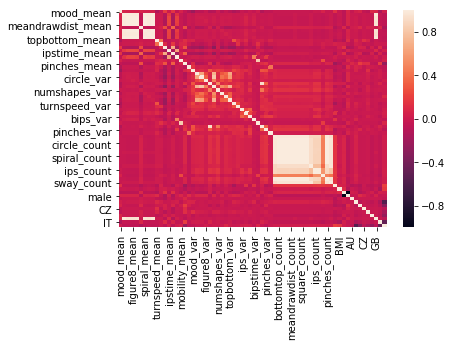

In [182]:
sns.heatmap(maindf.corr())

In [183]:
maindf.columns

Index(['diagnosis', 'mood_mean', 'bottomtop_mean', 'circle_mean',
       'figure8_mean', 'meandrawdist_mean', 'numshapes_mean', 'spiral_mean',
       'square_mean', 'topbottom_mean', 'turnspeed_mean', 'turns_mean',
       'ips_mean', 'ipstime_mean', 'bips_mean', 'bipstime_mean',
       'mobility_mean', 'pinches_mean', 'sway_mean', 'mood_var',
       'bottomtop_var', 'circle_var', 'figure8_var', 'shapehand_var',
       'meandrawdist_var', 'numshapes_var', 'spiral_var', 'square_var',
       'topbottom_var', 'turnspeed_var', 'turns_var', 'ips_var', 'ipstime_var',
       'bips_var', 'bipstime_var', 'mobility_var', 'pinchhand_var',
       'pinches_var', 'sway_var', 'mood_count', 'bottomtop_count',
       'circle_count', 'figure8_count', 'meandrawdist_count',
       'numshapes_count', 'spiral_count', 'square_count', 'topbottom_count',
       'turns_count', 'ips_count', 'bips_count', 'mobility_count',
       'pinches_count', 'sway_count', 'age', 'BMI', 'female', 'male', 'AU',
       'CA', 'CH

In [184]:
features = ['mood_mean', 'bottomtop_mean', 'circle_mean', 'figure8_mean',
       'meandrawdist_mean', 'numshapes_mean', 'spiral_mean', 'square_mean',
       'topbottom_mean', 'turnspeed_mean', 'turns_mean', 'ips_mean',
       'ipstime_mean', 'bips_mean', 'bipstime_mean', 'mobility_mean',
       'pinches_mean', 'sway_mean', 'mood_var', 'bottomtop_var', 'circle_var',
       'figure8_var', 'shapehand_var', 'meandrawdist_var', 'numshapes_var',
       'spiral_var', 'square_var', 'topbottom_var', 'turnspeed_var',
       'turns_var', 'ips_var', 'ipstime_var', 'bips_var', 'bipstime_var',
       'mobility_var', 'pinchhand_var', 'pinches_var', 'sway_var',
       'mood_count', 'bottomtop_count', 'circle_count', 'figure8_count',
       'meandrawdist_count', 'numshapes_count', 'spiral_count', 'square_count',
       'topbottom_count', 'turns_count', 'ips_count', 'bips_count',
       'mobility_count', 'pinches_count', 'sway_count', 'age', 'BMI']

In [179]:
maindf = maindf[ ['diagnosis'] + [ col for col in maindf.columns if col != 'diagnosis' ] ]

In [289]:
maindf.to_csv('maindf.csv')

Splitting data

In [185]:
vals = maindf.iloc[:, 1:]
diag = maindf.iloc[:, :1]

In [186]:
X_train, X_test, y_train, y_test = train_test_split(vals, diag, test_size = 0.2, random_state = 42)

baseline model

In [280]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [317]:
logregbase = LogisticRegression(random_state=42).fit(X_train,y_train)
print(logregbase.score(X_train, y_train, sample_weight=None))

y_pred = logregbase.predict(X_test)
training_preds = logregbase.predict(X_train)


logregbase.coef_

logregbase.intercept_

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Testing accuracy: {:.4}%".format(val_accuracy * 100))

0.6946778711484594
Training Accuracy: 69.47%
Testing accuracy: 73.74%


Random forest on cleaned data:

In [305]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
# forest.fit(data_train, target_train)
# forest.score(data_train, target_train)
# forest.score(data_test, target_test)

# pred = tree_clf.predict(data_test)
# print(confusion_matrix(target_test, pred))
# print(classification_report(target_test, pred))

# rfc=RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [100, 200, 300],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
#     'criterion' :['gini', 'entropy']
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(data_train, target_train)

# CV_rfc.best_params_

# rfc1=RandomForestClassifier(max_features='auto', n_estimators=300, max_depth=6, criterion='gini')
# rfc1.fit(data_train, target_train)
# pred=rfc1.predict(data_test)
# print("Accuracy for Random Forest on CV data: ",accuracy_score(target_test,pred))

In [295]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
print('Training score: ')
print(forest.score(X_train, y_train))
print('Testing Score: ')
print(forest.score(X_test, y_test))

Training score: 
0.9201680672268907
Testing Score
0.8491620111731844


In [303]:
prediction = forest.predict(X_test)

print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

[[77 13]
 [14 75]]
              precision    recall  f1-score   support

          HC       0.85      0.86      0.85        90
          MS       0.85      0.84      0.85        89

   micro avg       0.85      0.85      0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



In [327]:
param_grid = { 
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'criterion' :['gini', 'entropy']
}

grid_forest = GridSearchCV(estimator=forest, param_grid=param_grid, cv= 5)
grid_forest.fit(X_train, y_train)

grid_forest.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'log2',
 'n_estimators': 400}

In [329]:
rfc1=RandomForestClassifier(max_features='log2', n_estimators=400, max_depth=15, criterion='gini', random_state=42)
rfc1.fit(X_train, y_train)
pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test, pred))

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy for Random Forest on CV data:  0.8547486033519553
[[78 12]
 [14 75]]
              precision    recall  f1-score   support

          HC       0.85      0.87      0.86        90
          MS       0.86      0.84      0.85        89

   micro avg       0.85      0.85      0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



logistic regression with clean data and grid search

In [ ]:
logreg = LogisticRegression().fit(training,y_train)
logreg.score(training, y_train, sample_weight=None)
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(training,y_train)
logreg_cv.score(training, y_train)
logreg.coef_
logreg.intercept_
y_pred = logreg_cv.predict(testing)
confusion_matrix(y_test, y_pred)

In [341]:
logreg = LogisticRegression(random_state=42).fit(X_train,y_train)
logreg.score(X_train, y_train, sample_weight=None)

0.6946778711484594

In [346]:
grid={"C":np.logspace(-5,5,10), "penalty":["l1","l2"]}
logreggrid=LogisticRegression(random_state=42)
logreg_cv=GridSearchCV(logreggrid,grid,cv=5)
logreg_cv.fit(X_train,y_train)
logreg_cv.score(X_train, y_train)
y_pred = logreg_cv.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[71, 19],
       [19, 70]])

xgboost with clean data

In [330]:
import xgboost as xgb

In [334]:
xg = xgb.XGBClassifier(random_state=42)
xg.fit(X_train, y_train)
training_preds = xg.predict(X_train)
val_preds = xg.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

print(confusion_matrix(y_test, val_preds))
print(classification_report(y_test, val_preds))

Training Accuracy: 96.64%
Validation accuracy: 84.36%
[[77 13]
 [15 74]]
              precision    recall  f1-score   support

          HC       0.84      0.86      0.85        90
          MS       0.85      0.83      0.84        89

   micro avg       0.84      0.84      0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



In [339]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [1, 2, 3, 4, 5],
    'min_child_weight': [2, 5, 10, 20],
    'subsample': [0.6, 0.7, 0.8],
    'n_estimators': [10, 20, 50, 100, 250],
}

grid_xg = GridSearchCV(xg, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xg.fit(X_train, y_train)

best_parameters = grid_xg.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_xg.predict(X_train)
val_preds = grid_xg.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)


print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Testing Accuracy: {:.4}%".format(val_accuracy * 100))

print(confusion_matrix(y_test, val_preds))
print(classification_report(y_test, val_preds))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 4
min_child_weight: 5
n_estimators: 100
subsample: 0.7
Training Accuracy: 97.06%
Testing Accuracy: 82.12%
[[75 15]
 [17 72]]
              precision    recall  f1-score   support

          HC       0.82      0.83      0.82        90
          MS       0.83      0.81      0.82        89

   micro avg       0.82      0.82      0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



Below: PCA

In [188]:
pcax_train = X_train.iloc[:, :-11]
pcax_test = X_test.iloc[:, :-11]
pcay_train = y_train
pcay_test = y_test

In [189]:
# preprocess the data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [190]:
pcax_trainsc = scaler.fit_transform(pcax_train)
pcax_testsc = scaler.transform(pcax_test)

In [191]:
cols = []
for i in range(1, len(features)+1):
    cols.append('principal component {}'.format(i))

In [192]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponentstrain = pca.fit_transform(pcax_trainsc)
principalComponentstest = pca.transform(pcax_testsc)
principalDf = pd.DataFrame(data = principalComponentstrain, columns = cols)

In [193]:
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50,principal component 51,principal component 52,principal component 53,principal component 54,principal component 55
0,-0.306434,-0.387170,-0.020251,-0.395931,0.287246,-0.128255,-0.171453,-0.196668,-0.249584,0.144441,...,-0.013923,-0.007710,0.064041,0.002203,-0.002217,0.001758,-0.000998,-0.001145,-0.000887,-2.275424e-04
1,0.183541,-0.566343,-0.948464,-0.681137,-1.905727,2.412042,0.141963,0.299981,-0.129741,0.030257,...,0.005519,-0.000521,-0.009914,0.000951,0.000692,-0.000890,-0.000652,-0.000602,0.000009,3.128293e-05
2,-0.092406,-0.234847,-0.137715,0.637949,1.046547,0.138671,-1.043528,-0.401328,-1.717110,-1.246056,...,-0.014767,-0.006239,-0.009432,-0.003862,-0.000279,0.000093,-0.000580,-0.000439,0.001442,5.414982e-04
3,-1.545455,-0.431926,-0.786309,1.609957,0.107613,-0.444784,0.408823,0.134234,-0.254022,0.255177,...,0.002196,-0.004956,-0.001071,0.000191,0.000744,-0.000608,-0.000221,0.000128,0.000467,1.896114e-04
4,-1.531673,-0.483757,-1.104390,1.694268,0.172769,-1.108131,-0.294841,0.233590,-0.863099,-0.404119,...,-0.006619,0.000322,-0.003330,0.000157,0.002529,-0.003719,-0.000086,-0.000148,-0.000049,1.206749e-04
5,-1.605052,-0.439849,-0.531210,0.619372,-0.237219,-0.856485,0.807869,0.083431,1.614743,0.721768,...,-0.026354,-0.008452,0.000497,0.001743,0.002254,0.000803,-0.002979,0.000052,-0.000650,-6.669187e-04
6,-0.774453,-0.506182,0.254349,-1.677963,0.416266,-1.244799,-2.026294,0.726551,-0.952604,0.926994,...,-0.011955,0.009027,-0.016558,0.000681,-0.000464,0.001579,0.001584,0.001961,0.001007,-2.832715e-04
7,-0.535069,-0.613579,-0.187693,-2.319467,-0.869184,-0.527842,-1.165119,0.384143,0.539925,0.233394,...,-0.002265,-0.002033,0.000362,-0.001746,-0.001961,0.002854,-0.003044,-0.002622,-0.000144,-4.136421e-04
8,-0.307427,-0.360130,0.245412,-0.717619,0.560064,-0.021160,-0.819134,-0.149091,-1.018731,-0.624563,...,0.005897,-0.007272,-0.015312,-0.001881,-0.001281,-0.000608,0.000158,0.001579,0.000158,3.402713e-04
9,-0.956908,-0.370371,1.054702,-1.024490,0.496312,-0.256491,-2.036009,0.798524,-1.708888,0.633010,...,-0.015322,0.075421,-0.001670,-0.003039,-0.000234,0.000383,0.000496,0.000528,-0.000095,-6.532276e-04


In [194]:
pca.explained_variance_ratio_

array([2.52215038e-01, 1.30000116e-01, 8.12040900e-02, 4.80425512e-02,
       3.89484680e-02, 3.53908072e-02, 3.25167050e-02, 2.98156721e-02,
       2.86728409e-02, 2.34647621e-02, 2.23304814e-02, 1.96882324e-02,
       1.85135383e-02, 1.78706378e-02, 1.72201108e-02, 1.62974787e-02,
       1.52590429e-02, 1.46994035e-02, 1.44429227e-02, 1.34382649e-02,
       1.26185627e-02, 1.19937290e-02, 1.15541340e-02, 1.14028733e-02,
       1.07666219e-02, 9.72271367e-03, 9.60247687e-03, 8.85145693e-03,
       8.26252462e-03, 7.61728068e-03, 5.56438817e-03, 4.90189251e-03,
       4.70627485e-03, 2.95269175e-03, 2.64496751e-03, 2.14274087e-03,
       1.37913678e-03, 1.32377646e-03, 4.95320728e-04, 4.90714374e-04,
       4.16790998e-04, 2.57779068e-04, 1.24732260e-04, 8.16891981e-05,
       3.17885015e-05, 2.13262740e-05, 1.92122740e-05, 1.42519761e-05,
       2.74434349e-06, 1.73819973e-06, 1.13212082e-06, 7.04919640e-07,
       4.23531772e-07, 1.70088582e-07, 7.47135872e-08])

In [195]:
pca.explained_variance_

array([1.38912827e+01, 7.16003442e+00, 4.47248894e+00, 2.64604626e+00,
       2.14517018e+00, 1.94922440e+00, 1.79092708e+00, 1.64216191e+00,
       1.57921804e+00, 1.29237196e+00, 1.22989903e+00, 1.08437151e+00,
       1.01967272e+00, 9.84263602e-01, 9.48434436e-01, 8.97618495e-01,
       8.40424427e-01, 8.09601085e-01, 7.95474860e-01, 7.40141180e-01,
       6.94994331e-01, 6.60580279e-01, 6.36368643e-01, 6.28037633e-01,
       5.92994728e-01, 5.35499251e-01, 5.28876952e-01, 4.87512922e-01,
       4.55076216e-01, 4.19538026e-01, 3.06470580e-01, 2.69982215e-01,
       2.59208154e-01, 1.62625814e-01, 1.45677243e-01, 1.18016037e-01,
       7.59589080e-02, 7.29098200e-02, 2.72808485e-02, 2.70271437e-02,
       2.29556557e-02, 1.41977335e-02, 6.86989600e-03, 4.49920731e-03,
       1.75081971e-03, 1.17459015e-03, 1.05815708e-03, 7.84958065e-04,
       1.51150587e-04, 9.57350681e-05, 6.23539756e-05, 3.88249569e-05,
       2.33269182e-05, 9.36799247e-06, 4.11501061e-06])

In [196]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
# print(eig_values)
# print(eig_vectors)

In [197]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]

In [198]:
structure_loading_1 = pc1* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=features)
str_loading_1.sort_values(ascending = False)

pinches_count         0.994958
meandrawdist_count    0.993985
numshapes_count       0.993387
figure8_count         0.993116
spiral_count          0.993024
circle_count          0.992958
topbottom_count       0.992933
bottomtop_count       0.992879
square_count          0.992755
mood_count            0.983597
sway_count            0.956755
turns_count           0.919663
bips_count            0.915100
ips_count             0.914813
mobility_count        0.523783
pinches_var           0.211592
numshapes_var         0.202239
shapehand_var         0.179250
pinchhand_var         0.166810
age                   0.156983
meandrawdist_var      0.145321
square_var            0.142654
turns_var             0.130956
bottomtop_var         0.120860
circle_var            0.115875
topbottom_var         0.105352
pinches_mean          0.086433
ips_var               0.084998
mood_var              0.077879
bips_var              0.075694
spiral_var            0.072834
numshapes_mean        0.054374
turnspee

In [199]:
structure_loading_2 = pc2* np.sqrt(eig_values[1])
str_loading_2 = pd.Series(structure_loading_2, index=features)
str_loading_2.sort_values(ascending = False)

circle_mean           0.989659
figure8_mean          0.988983
meandrawdist_mean     0.988824
spiral_mean           0.987807
topbottom_mean        0.986952
square_mean           0.973947
bottomtop_mean        0.970852
bipstime_mean         0.292715
ipstime_mean          0.280447
ipstime_var           0.123085
meandrawdist_var      0.117547
bottomtop_var         0.108951
topbottom_var         0.100453
circle_var            0.096691
square_var            0.090344
spiral_var            0.086489
bipstime_var          0.081488
figure8_var           0.050094
ips_var               0.049762
turns_count           0.042955
bips_var              0.040926
sway_count            0.039528
numshapes_count       0.036019
mood_mean             0.023383
pinches_count         0.018226
meandrawdist_count    0.018200
square_count          0.017754
figure8_count         0.017302
topbottom_count       0.017277
circle_count          0.017250
bottomtop_count       0.017193
spiral_count          0.017120
mood_cou

In [200]:
structure_loading_3 = pc1* np.sqrt(eig_values[2])
str_loading_3 = pd.Series(structure_loading_3, index=features)
str_loading_3.sort_values(ascending = False)

pinches_count         0.564558
meandrawdist_count    0.564005
numshapes_count       0.563666
figure8_count         0.563512
spiral_count          0.563460
circle_count          0.563423
topbottom_count       0.563408
bottomtop_count       0.563378
square_count          0.563308
mood_count            0.558111
sway_count            0.542880
turns_count           0.521834
bips_count            0.519244
ips_count             0.519082
mobility_count        0.297204
pinches_var           0.120061
numshapes_var         0.114754
shapehand_var         0.101710
pinchhand_var         0.094651
age                   0.089075
meandrawdist_var      0.082458
square_var            0.080945
turns_var             0.074307
bottomtop_var         0.068578
circle_var            0.065749
topbottom_var         0.059779
pinches_mean          0.049044
ips_var               0.048230
mood_var              0.044190
bips_var              0.042950
spiral_var            0.041328
numshapes_mean        0.030853
turnspee

Text(0, 0.5, 'proportion of explained variance')

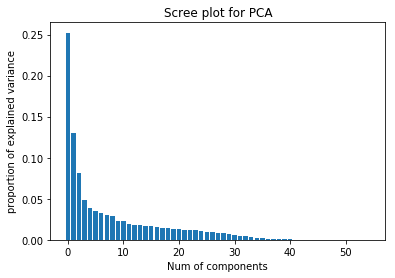

In [201]:
index = np.arange(len(features))
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')

Text(0, 0.5, 'explained variance ratio')

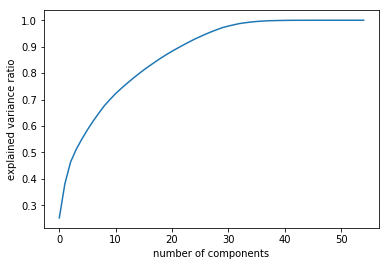

In [202]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')

In [226]:
pcstrain = principalDf.iloc[:, :3]

In [227]:
dumtrain = X_train.iloc[:, -11:]
dumtest = X_test.iloc[:, -11:]

In [228]:
pcstrain.set_index(dumtrain.index, inplace = True)

In [229]:
training = dumtrain.merge(pcstrain, left_index=True, right_index=True)
# training = training dataset after PCA; y_train is training results

In [230]:
principaldftest = pd.DataFrame(data = principalComponentstest, columns = cols)

In [231]:
pcstest = principaldftest.iloc[:, :3]
pcstest.set_index(dumtest.index, inplace = True)
testing = dumtest.merge(pcstest, left_index = True, right_index=True)
# testing = testing dataset after PCA; y_test is test results

above: splitting data after PCA

below: logistic regression

In [241]:
from sklearn.linear_model import LogisticRegression

In [251]:
logreg = LogisticRegression().fit(training,y_train)
logreg.score(vals, , sample_weight=None)

0.6820728291316527

In [245]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(training,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [248]:
logreg_cv.score(training, y_train)

0.680672268907563

In [252]:
logreg.coef_

array([[ 3.31412789e-01, -8.42856865e-01,  0.00000000e+00,
         3.08281415e-01, -1.21830062e+00,  5.33583115e-01,
        -1.02442818e+00, -8.87681331e-01, -1.89423689e-04,
         8.39053352e-01,  9.38237604e-01,  2.13167600e-01,
         2.33443454e-01, -3.90333639e-02]])

In [253]:
logreg.intercept_

array([-0.51144408])

In [254]:
y_pred = logreg_cv.predict(testing)

In [256]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[58, 32],
       [18, 71]])

In [ ]:
############

below: xgboost

In [257]:
import xgboost as xgb

In [263]:
maindf.diagnosis.value_counts()

HC    455
MS    438
Name: diagnosis, dtype: int64

In [262]:
xg = xgb.XGBClassifier()
xg.fit(training, y_train)
training_preds = xg.predict(training)
val_preds = xg.predict(testing)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Testing accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 82.49%
Testing accuracy: 65.92%


In [274]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [1, 2, 3, 4, 5],
    'min_child_weight': [5, 10, 20],
    'subsample': [0.7, 0.8],
    'n_estimators': [5, 30, 100, 250],
}

grid_xg = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xg.fit(training, y_train)

best_parameters = grid_xg.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_xg.predict(training)
val_preds = grid_xg.predict(testing)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 10
n_estimators: 30
subsample: 0.8

Training Accuracy: 75.35%
Validation accuracy: 68.72%


In [275]:
confusion_matrix(y_test, val_preds)

array([[62, 28],
       [28, 61]])

In [ ]:
#######

In [259]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [65]:
data = forlog[forlog.columns[2:-1]]
target = forlog.diagnosis

In [679]:
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                                   test_size = 0.25, random_state=123)

In [712]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(data_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [713]:
forest.score(data_train, target_train)

0.7548579970104634

In [685]:
forest.score(data_test, target_test)


0.6205357142857143

In [690]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [299]:
pred = forest.predict(data_test)
print(confusion_matrix(target_test, pred))
print(classification_report(target_test, pred))

NameError: name 'data_test' is not defined

In [691]:
rfc=RandomForestClassifier(random_state=42)


In [702]:
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 4, 5, 6, 7, 8, 9, 10],
    'criterion' :['gini', 'entropy']
}

In [703]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(data_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [704]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 300}

In [723]:
rfc1=RandomForestClassifier(max_features='auto', n_estimators=300, max_depth=6, criterion='gini')
rfc1.fit(data_train, target_train)
pred=rfc1.predict(data_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(target_test,pred))

Accuracy for Random Forest on CV data:  0.625


In [60]:
import xgboost as xgb


In [66]:
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))